#**Set up the enviroment**

In [ ]:
import os
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import random
from tables import *
import math
import seaborn as sns
from scipy import ndimage
from tensorflow import keras

from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate,Conv3D, MaxPooling3D,Input, BatchNormalization,UpSampling3D,Reshape

from keras import backend as K
from keras import optimizers

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from datetime import datetime
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime
import pandas as pd
import random
import h5py

In [ ]:
#Seed value set to 0 to ensure reproducibility of data
seed_value= 0

#Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

#Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

#Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

#Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
root = '/content/gdrive/MyDrive/Neuroengineering'
os.makedirs(root, exist_ok=True)

#**Load Dataset**

In [ ]:
#Importing .h5 files
h5file = open_file("/content/gdrive/MyDrive/PW1_AY2223/Data/FPreductionDataset_v3.h5", mode = "r")

In [ ]:
# Show target variable
y = np.array(h5file.root.target)
print(y)
print(len(y))

[0 0 0 ... 1 1 1]
7161


# **Plotting the distributions of the two classes**

In [ ]:
class_zero = len(np.where(y==0)[0])
class_one = len(np.where(y==1)[0])
print(('The number of FP is equal to: {}').format(str(class_zero)))
print(('The number of TP is equal to: {}').format(str(class_one)))

The number of FP is equal to: 6082
The number of TP is equal to: 1079


In [ ]:
graph = os.path.join(root, 'graph_notes')
os.makedirs(graph, exist_ok=True)

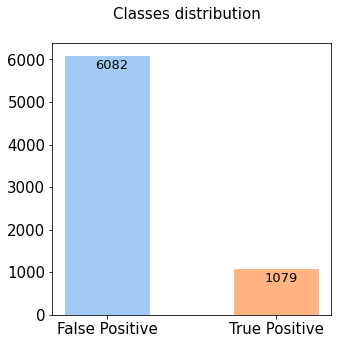

In [ ]:
names = ['False Positive', 'True Positive']
values = [class_zero, class_one]

fig = plt.figure(figsize=(5, 5))
fig.suptitle('Classes distribution', fontsize = 15)

ax = fig.add_subplot(1, 1, 1) 
y_pos = [1,1.5]
plt.bar(y_pos, values, color=sns.color_palette('pastel'),width=0.25)
for index, value in enumerate(y_pos):
    plt.text(value-0.035, values[index]-300, str(values[index]),
     fontsize=13)
plt.xticks(y_pos, names, fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()
fig.savefig(os.path.join(graph, 'Classes distribution'), facecolor=fig.get_facecolor())

# **Visualization of image patches**

In [ ]:
IDX_class_zero = np.where(y==0)[0]
IDX_class_one = np.where(y==1)[0]

In [ ]:
def normalize(x_img):
    MIN_BOUND = -1200.0
    MAX_BOUND = 600.0
    PIXEL_MEAN = 0.12  
    PIXEL_CORR = int((MAX_BOUND - MIN_BOUND) * PIXEL_MEAN) 
    x_img -= PIXEL_CORR 
    x_img[x_img>MAX_BOUND] = MAX_BOUND 
    x_img[x_img<MIN_BOUND] = MIN_BOUND 
    x_img = ((x_img - (MIN_BOUND)) / (MAX_BOUND - (MIN_BOUND)))
    
    return x_img

5088
4047
501
2465
6907
4693
5383
2884
6434
3429


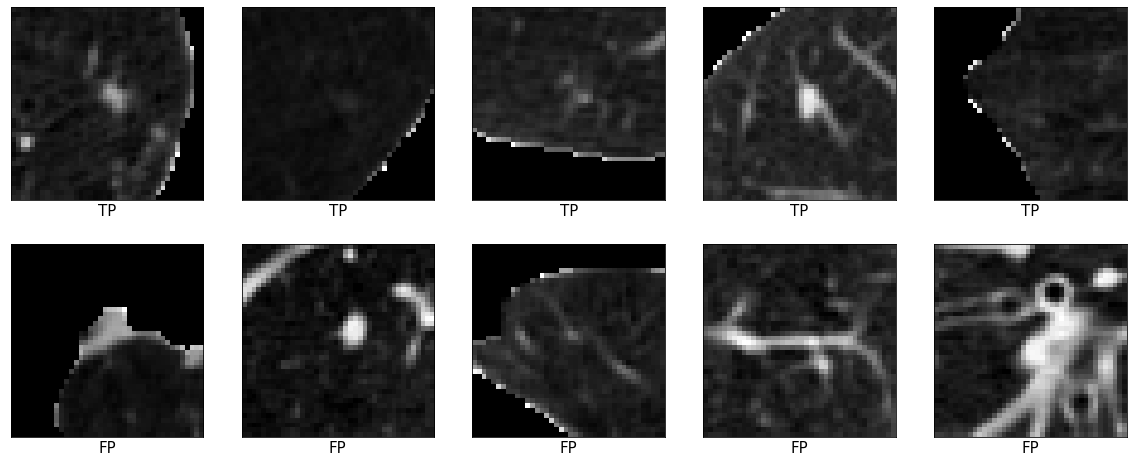

In [ ]:
# Display examples of the dataset
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    TPidx = random.randrange(len(IDX_class_one))
    image = normalize(h5file.root.images[IDX_class_one[TPidx],12,:,:])   
    plt.imshow(image,cmap='gray')
    plt.xlabel('TP', fontsize = 15)
    plt.xticks([])
    plt.yticks([])
    print(IDX_class_one[TPidx])
    plt.subplot(2,5,i+6)
    FPidx = random.randrange(len(IDX_class_zero))
    image = normalize(h5file.root.images[IDX_class_zero[FPidx],12,:,:])  
    plt.imshow(image,cmap='gray')
    plt.xlabel('FP', fontsize = 15)
    plt.xticks([])
    plt.yticks([])
    print(IDX_class_zero[FPidx])

(40, 40)

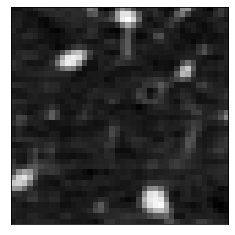

In [ ]:
image = normalize(h5file.root.images[IDX_class_zero[FPidx],23,:,:]) 
plt.imshow(image,cmap='gray')
plt.xticks([])
plt.yticks([])
np.shape(image)

# **Split the dataset**

In [ ]:
ptIDall =  h5file.root.anonID[0:]
ptUnique =  list(set(ptIDall))

print(" The total number of patients in the dataset is equal to {}".format(len(ptUnique)))
random.seed(4)
random.shuffle(ptUnique)

ptIDall =  h5file.root.anonID[0:]

ptUnique =  list(set(ptIDall))

random.seed(4)
random.shuffle(ptUnique)

Ntr = int(len(ptUnique)*0.70)
Nval = len(ptUnique)-Ntr

ptTrain = ptUnique[0:Ntr]
ptVal = ptUnique[Ntr:]
print(" The total number of patients in the training set is equal to {}".format(Ntr))
print(" The total number of patients in the validation set is equal to {}".format(Nval))


idx_train = np.where(np.isin(ptIDall,ptTrain))[0]
idx_val = np.where(np.isin(ptIDall,ptVal))[0]

print(" The total number of images is equal to {}".format(len(ptIDall)))

 The total number of patients in the dataset is equal to 81
 The total number of patients in the training set is equal to 56
 The total number of patients in the validation set is equal to 25
 The total number of images is equal to 7161


In [ ]:
y = np.array(h5file.root.target)
y_train = y[idx_train]

train_zero = len(np.where(y[idx_train]==0)[0])
train_one = len(np.where(y[idx_train]==1)[0])
print('N = {} samples labelled as 0 in training set'.format(len(np.where(y[idx_train]==0)[0])))
print('N = {} samples labelled as 1 in training set'.format(len(np.where(y[idx_train]==1)[0])))

validation_zero = len(np.where(y[idx_val]==0)[0])
validation_one = len(np.where(y[idx_val]==1)[0])
print('N = {} samples labelled as 0 in validation set'.format(len(np.where(y[idx_val]==0)[0])))
print('N = {} samples labelled as 1 in validation set'.format(len(np.where(y[idx_val]==1)[0])))

print('The training set has {} samples'.format(len(idx_train)))
print('The validation set has {} samples'.format(len(idx_val)))


percentage_training = round(len(idx_train)*100/len(y))
percentage_validation = round(len(idx_val)*100/len(y))

print('The training set is the {}% of the dataset samples'.format(percentage_training))
print('The validation set is the {}% of the dataset samples'.format(percentage_validation))

# CREATE THE VECTOR OF TARGETS:
# If we are using a softmax function in the output layer, we need to create a two column vector where
# the first column corresponds to the probability of being 1 while the second to the probability of being 0 
y = np.transpose(np.array([y,(1-y)]))
print(('The new shape of the target vector is {}').format(np.shape(y)))

# 0 = FP
# 1 = TP

N = 3727 samples labelled as 0 in training set
N = 737 samples labelled as 1 in training set
N = 2355 samples labelled as 0 in validation set
N = 342 samples labelled as 1 in validation set
The training set has 4464 samples
The validation set has 2697 samples
The training set is the 62% of the dataset samples
The validation set is the 38% of the dataset samples
The new shape of the target vector is (7161, 2)


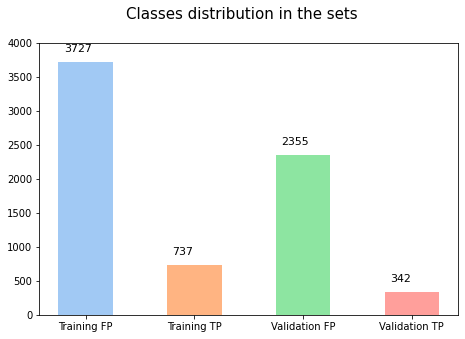

In [ ]:
#PLOTTING CLASSES DISTRIBUTION IN TRAINING AND VALIDATION

names = ['Training FP', 'Training TP', 'Validation FP', 'Validation TP']
        
values = [train_zero, train_one, validation_zero, validation_one]

fig = plt.figure(figsize=(7.5, 5))
fig.suptitle('Classes distribution in the sets', fontsize = 15)

ax = fig.add_subplot(1,1,1) 

ax.set_ylim([0,4000])
y_pos = [1,1.5,2,2.5]
for index, value in enumerate(y_pos):
    plt.text(value-0.1, values[index]+150, str(values[index]), fontsize=11)
plt.bar(y_pos, values, color=sns.color_palette('pastel'),width=0.25)
plt.xticks(y_pos, names )

plt.show
fig.savefig(os.path.join(graph, 'Classes distribution in the sets_1'), facecolor=fig.get_facecolor())

#**Model architecture definition**

In [ ]:
# ARCH_1
input_layer1 = keras.layers.Input(shape = (6,20,20,1))

C1 = tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(input_layer1)


M1 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C1)


C2 =  tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(M1)

M2 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C2)
                                
C3 =  tf.keras.layers.Conv3D( filters=32,
                              kernel_size=(3,5,5),
                              padding="same",
                              activation="relu")(M2)

F0 = tf.keras.layers.Flatten()(C3)

DP1 = tf.keras.layers.Dropout(0.2)(F0)

FC1 =  tf.keras.layers.Dense(units =64,
                          activation = 'relu',
                          use_bias = True)(DP1)

DP2 = tf.keras.layers.Dropout(0.3)(FC1)

FC2 =  tf.keras.layers.Dense(units = 64,
                          activation = 'relu',
                          use_bias = True)(DP2)

DP3 = tf.keras.layers.Dropout(0.4)(FC2)

output_layer1 = tf.keras.layers.Dense( units = 2, activation="softmax")(DP3)

In [ ]:
model1 = keras.Model(inputs=input_layer1,
                    outputs=output_layer1,
                    name="ARCH_1_model")

In [ ]:
model1.summary()

Model: "ARCH_1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 20, 20, 1)]    0         
                                                                 
 conv3d (Conv3D)             (None, 6, 20, 20, 32)     2432      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 10, 10, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 10, 10, 32)     76832     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 5, 5, 32)      0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 5, 5, 32)      

In [ ]:
#ARCH_2
input_layer2 = tf.keras.layers.Input(shape = (10,30,30,1))

C1 = tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(input_layer2)


M1 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C1)

C2 =  tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(M1)

M2 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C2)
                                
C3 =  tf.keras.layers.Conv3D( filters=32,
                              kernel_size=(3,5,5),
                              padding="same",
                              activation="relu")(M2)

M3 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C3)

F0 = tf.keras.layers.Flatten()(M3)

DP1 = tf.keras.layers.Dropout(0.2)(F0)

FC1 =  tf.keras.layers.Dense(units =64,
                          activation = 'relu',
                          use_bias = True)(DP1)

DP2 = tf.keras.layers.Dropout(0.3)(FC1)

FC2 =  tf.keras.layers.Dense(units = 64,
                          activation = 'relu',
                          use_bias = True)(DP2)

DP3 = tf.keras.layers.Dropout(0.4)(FC2)

output_layer2 = tf.keras.layers.Dense( units = 2, activation="softmax")(DP3)



In [ ]:
model2 = keras.Model(inputs=input_layer2,
                    outputs=output_layer2,
                    name="ARCH_2_model")

In [ ]:
model2.summary()

Model: "ARCH_2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 30, 30, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 30, 30, 32)    2432      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 15, 15, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 15, 15, 32)    76832     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 8, 8, 32)      0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 5, 8, 8, 32)      

In [ ]:
#ARCH_3
input_layer3 = tf.keras.layers.Input(shape = (26,40,40,1))

C1 = tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(input_layer3)


M1 =  tf.keras.layers.MaxPooling3D( pool_size= (1,2,2),
                                  padding="same"
                                )(C1)

C2 =  tf.keras.layers.Conv3D(filters=32,
                             kernel_size=(3,5,5),
                             padding="same",
                             activation="relu")(M1)

M2 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C2)
                                
C3 =  tf.keras.layers.Conv3D( filters=32,
                              kernel_size=(3,5,5),
                              padding="same",
                              activation="relu")(M2)

M3 =  tf.keras.layers.MaxPooling3D( pool_size= (2,2,2),
                                  padding="same"
                                )(C3)

F0 = tf.keras.layers.Flatten()(M3)

DP1 = tf.keras.layers.Dropout(0.2)(F0)

FC1 =  tf.keras.layers.Dense(units =64,
                          activation = 'relu',
                          use_bias = True)(DP1)

DP2 = tf.keras.layers.Dropout(0.3)(FC1)

FC2 =  tf.keras.layers.Dense(units = 64,
                          activation = 'relu',
                          use_bias = True)(DP2)

DP2 = tf.keras.layers.Dropout(0.4)(FC2)

output_layer3 = tf.keras.layers.Dense( units = 2, activation="softmax")(DP2)

In [ ]:
model3 = keras.Model(inputs=input_layer3,
                    outputs=output_layer3,
                    name="ARCH_3_model")

In [ ]:
model3.summary()

Model: "ARCH_3_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26, 40, 40, 1)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 26, 40, 40, 32)    2432      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 26, 20, 20, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 26, 20, 20, 32)    76832     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 13, 10, 10, 32)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 13, 10, 10, 32)   

# **Loader function**

In [ ]:
#Image Loader MODEL 1
def imageLoader(files, idx_samples,target, batch_size, dimIM):
    L = len(idx_samples)
    
    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)
     
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            #We have to allocate in advance the space for the input batch
            tmpB = np.empty((limit-batch_start,dimIM[0],dimIM[1],dimIM[2]))
            
            idx =-1
            for i in range(batch_start,limit):
                idx=idx+1
                #Ranges has to be updated according to the input size we are dealing with
                img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],10:16,10:30,10:30],axis=0)

                #Image processing
                img_0 = normalize(img_0)
                #From the value in the second column verify which transformation apply 
                angle = idx_samples[i,1]
                if angle == 1:
                    img = np.flip(img_0,axis=3) #Horizontal FLIP 
                elif angle ==2:
                    img = np.flip(img_0,axis=2) #Vertical FLIP 
                elif angle >2 :
                    img = ndimage.rotate(img_0,angle,reshape=False,mode='constant',axes = (2,3))
                elif angle == 0: #Original image is considered
                    img = img_0
                #Fill the allocated vector with the tranformed image
                tmpB[idx,:,:,:] =img


            X = np.expand_dims(tmpB,axis=-1)

            Y = target[idx_samples[batch_start:limit,0],:]
            
            #SINGLE INPUT- SINGLE OUTPUT
            yield (X,Y) #A tuple with two numpy arrays with batch_size samples     
            
            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
#Image Loader MODEL 2
def imageLoader2(files, idx_samples,target, batch_size, dimIM2):
    L = len(idx_samples)
    
    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)
     
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            #We have to allocate in advance the space for the input batch
            tmpB = np.empty((limit-batch_start,dimIM2[0],dimIM2[1],dimIM2[2]))
            
            idx =-1
            for i in range(batch_start,limit):
                idx=idx+1
                # Ranges has to be updated according to the input size we are dealing with
                img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],10:20,10:40,10:40],axis=0)

                #Image processing
                img_0 = normalize(img_0)
                #From the value in the second column verify which transformation apply 
                angle = idx_samples[i,1]
                if angle == 1:
                    img = np.flip(img_0,axis=3) #Horizontal FLIP 
                elif angle ==2:
                    img = np.flip(img_0,axis=2) #Vertical FLIP 
                elif angle >2 :
                    img = ndimage.rotate(img_0,angle,reshape=False,mode='constant',axes = (2,3))
                elif angle == 0: #Original image is considered
                    img = img_0
                #Fill the allocated vector with the tranformed image
                tmpB[idx,:,:,:] =img


            X = np.expand_dims(tmpB,axis=-1)

            Y = target[idx_samples[batch_start:limit,0],:]
            
            #SINGLE INPUT- SINGLE OUTPUT
            yield (X,Y) #A tuple with two numpy arrays with batch_size samples     
            
            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
#Image Loader MODEL 3   
def imageLoader3(files, idx_samples,target, batch_size, dimIM3):
    L = len(idx_samples)
    
    print(idx_samples.shape)
    idx_samples = K.print_tensor(idx_samples)
    np.random.shuffle(idx_samples)
     
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_end <= L:
            limit = min(batch_end, L)

            #We have to allocate in advance the space for the input batch
            tmpB = np.empty((limit-batch_start,dimIM3[0],dimIM3[1],dimIM3[2]))
            
            idx =-1
            for i in range(batch_start,limit):
                idx=idx+1
                #Ranges has to be updated according to the input size we are dealing with
                
                img_0 =  np.expand_dims(files.root.images[idx_samples[i,0],0:26,0:40,0:40],axis=0)

                #Image processing
                img_0 = normalize(img_0)
                #From the value in the second column verify which transformation apply 
                angle = idx_samples[i,1]
                if angle == 1:
                    img = np.flip(img_0,axis=3) #Horizontal FLIP 
                elif angle ==2:
                    img = np.flip(img_0,axis=2) #Vertical FLIP 
                elif angle >2 :
                    img = ndimage.rotate(img_0,angle,reshape=False,mode='constant',axes = (2,3))
                elif angle == 0: #Original image is considered
                    img = img_0
                #Fill the allocated vector with the tranformed image
                tmpB[idx,:,:,:] =img


            X = np.expand_dims(tmpB,axis=-1)

            Y = target[idx_samples[batch_start:limit,0],:]
            
           
            #SINGLE INPUT- SINGLE OUTPUT
            yield (X,Y) #A tuple with two numpy arrays with batch_size samples     
            
            batch_start += batch_size   
            batch_end += batch_size
          

# **Image processing**
#### Pixel values are expressed in Housfield Units (HU). We rescale them in the range 0 -1 through a normalization operation.

In [ ]:
def normalize(x_img):
    MIN_BOUND = -1200.0
    MAX_BOUND = 600.0
    PIXEL_MEAN = 0.12 
    PIXEL_CORR = int((MAX_BOUND - MIN_BOUND) * PIXEL_MEAN) 
    x_img -= PIXEL_CORR
    x_img[x_img>MAX_BOUND] = MAX_BOUND
    x_img[x_img<MIN_BOUND] = MIN_BOUND
    x_img = ((x_img - (MIN_BOUND)) / (MAX_BOUND - (MIN_BOUND)))
    
    return x_img

#**Dataset generation**
###Train dataset

In [ ]:
#MODEL1
# Verify that image ranges are correct and that fit the required input shape 
# this ranges must be changed in the "imageLoader" function
IM = h5file.root.images[0,10:16,10:30,10:30]
dimIM = np.shape(IM) #[depth, height, width]
print(dimIM)

(6, 20, 20)


In [ ]:
#MODEL2
# Verify that image ranges are correct and that fit the required input shape 
# this ranges must be changed in the "imageLoader" function
IM2 = h5file.root.images[0,10:20,10:40,10:40]
dimIM2 = np.shape(IM2) #[depth, height, width]
print(dimIM2)

(10, 30, 30)


In [ ]:
#MODEL3
# Verify that image ranges are correct and that fit the required input shape 
# this ranges must be changed in the "imageLoader" function
IM3 = h5file.root.images[0,0:26,0:40,0:40]
dimIM3 = np.shape(IM3) #[depth, height, width]
print(dimIM3)

(26, 40, 40)


In [ ]:
idx_trainNEWRE = np.empty((np.shape(idx_train)[0],),dtype=int)
for i in range(len(idx_train)):
    idx_trainNEWRE[i] = int(idx_train[i])

In [ ]:
# Indexes of FP samples
idx_train_FP = idx_trainNEWRE[np.where(y[idx_trainNEWRE,0]==0)[0]]
# Indexes of TP samples
idx_train_TP = idx_trainNEWRE[np.where(y[idx_trainNEWRE,0]==1)[0]]


#**Data Augmentation**
##### We augmented both the minority and majority classes

In [ ]:
#How many times we want to replicate the minority class:
Naugment_TP = 9

In [ ]:
#How many times we want to replicate the majority class:
Naugment_FP = 1

In [ ]:
#Concatenate the indexes of the training samples for a number of times equal to Naugment_TP
idx_train_TP_augmented=idx_train_TP
count = Naugment_TP
while count > 0 :
  count = count - 1
  idx_train_TP_augmented =np.concatenate((idx_train_TP_augmented,idx_train_TP),axis=0)
print(np.shape(idx_train_TP_augmented))

(7370,)


In [ ]:
#Concatenate the indexes of the training samples for a number of times equal to Naugment_FP
idx_train_FP_augmented=idx_train_FP
count = Naugment_FP
while count > 0 :
  count = count - 1
  idx_train_FP_augmented =np.concatenate((idx_train_FP_augmented,idx_train_FP),axis=0)
print(np.shape(idx_train_FP_augmented))

(7454,)


In [ ]:
#The possible transformations are encoded as follows:
# - 0 : original image
# - 1 : horizontal flip 
# - 2 : vertical flip
# - >2 : rotation of xx degree
angles_list = [0,90,180,270]

#Random choice of the rotation angle for both majority and minority class
angles_FP = np.random.choice(angles_list,idx_train_FP_augmented.shape)
print(angles_FP.shape)

angles_TP = np.random.choice(angles_list,idx_train_TP_augmented.shape)
print(angles_TP.shape)


(7454,)
(7370,)


In [ ]:
#Merge indexes and tranformation vectors of the two classes
idx_trainNEWRE = np.concatenate((idx_train_FP_augmented,idx_train_TP_augmented),axis=0)
angles_array = np.concatenate((angles_FP,angles_TP),axis=0)
#Concatenate vector of indexes and of transformation
idx_angles_training = np.asarray(np.concatenate((np.expand_dims(idx_trainNEWRE,axis=1),
                                                 np.expand_dims(angles_array,axis=1)),axis=1),dtype=int)
print(idx_angles_training.shape)
y_train = y[idx_trainNEWRE]
print(y[idx_trainNEWRE])
print(np.shape(y[idx_trainNEWRE]))
print(idx_train_FP_augmented)


(14824, 2)
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
(14824, 2)
[ 256  257  259 ... 7145 7146 7147]


In [ ]:
# SET BATCH SIZE
batch_size = 150
#Steps per epoch depend on the batch size
steps = len(idx_trainNEWRE)//batch_size
print(steps)

# DEFINE THE IMAGE GENERATOR

training_generator = imageLoader(h5file, idx_angles_training, y, batch_size, dimIM)
training_generator2 = imageLoader2(h5file, idx_angles_training, y, batch_size, dimIM2)
training_generator3 = imageLoader3(h5file, idx_angles_training, y, batch_size, dimIM3)
y_target = y
print(y_target)

98
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


#**Validation dataset**

In [ ]:
#Model 1
val_images =  np.expand_dims(h5file.root.images[list(idx_val),10:16,10:30,10:30],axis=-1)
val_images = normalize(val_images)
      
print(np.shape(val_images))
print(idx_val[0])


#Model 2
val_images2 =  np.expand_dims(h5file.root.images[list(idx_val),10:20,10:40,10:40],axis=-1)
val_images2 = normalize(val_images2)
        
print(np.shape(val_images2))
print(idx_val[0])

#Model 3
val_images3 =  np.expand_dims(h5file.root.images[list(idx_val),0:26,0:40,0:40],axis=-1)
val_images3 = normalize(val_images3)
        
print(np.shape(val_images3))
print(idx_val[0])


val_labels = y[list(idx_val)] 
print(np.shape(val_labels))

(2697, 6, 20, 20, 1)
0
(2697, 10, 30, 30, 1)
0
(2697, 26, 40, 40, 1)
0
(2697, 2)


#**Compilation**

###**Custom Loss**

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
def custom_crossentropy(bce):
    def loss(y_true, y_pred):
      
      y_true = y_true[:,0:2]
      
      unweighted_loss = bce(y_true, y_pred)
      return unweighted_loss  

    return loss

###**Custom Metrics**

In [ ]:
def recall(y_true, y_pred):
    y_true = y_true [:,0:2]
    y_true = y_true [:,0]
    y_pred = y_pred [:,0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_v = true_positives / (possible_positives + K.epsilon())
    return recall_v

def precision(y_true, y_pred):
    y_true = y_true [:,0:2]
    y_true = y_true [:,0]
    y_pred = y_pred [:,0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_v = true_positives / (predicted_positives + K.epsilon())
    return precision_v

def f1score(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

**MODEL 1**

In [ ]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model1.compile(
    loss= custom_crossentropy(bce),
    optimizer=adam,
    metrics=['acc',f1score,precision, recall]
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


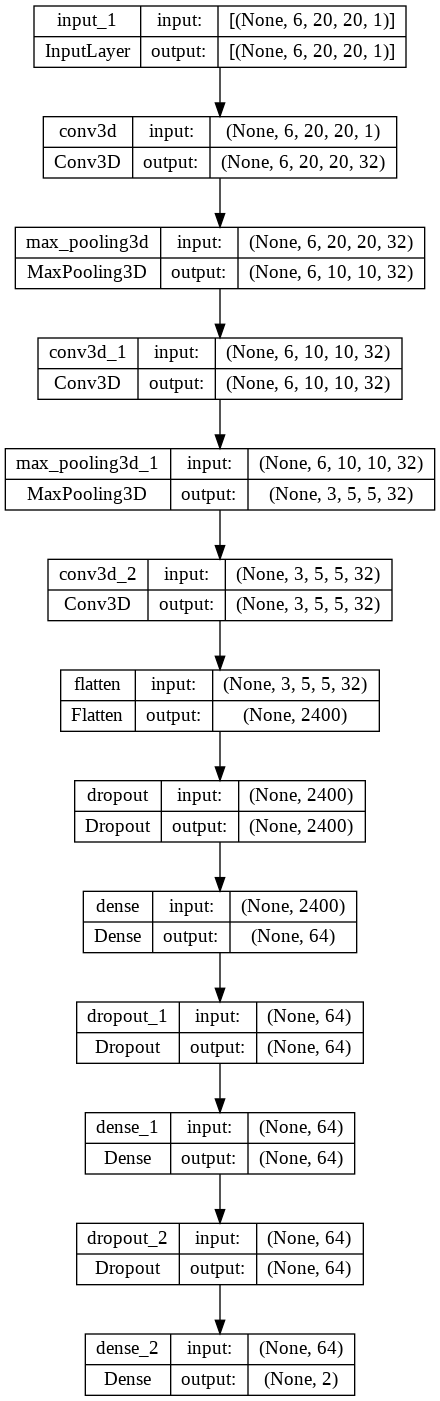

In [ ]:
plot_model(model1,show_shapes=True, show_layer_names=True)

**MODEL 2**

In [ ]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model2.compile(
    loss= custom_crossentropy(bce),
    optimizer=adam,
    metrics=['acc',f1score,precision, recall]
)


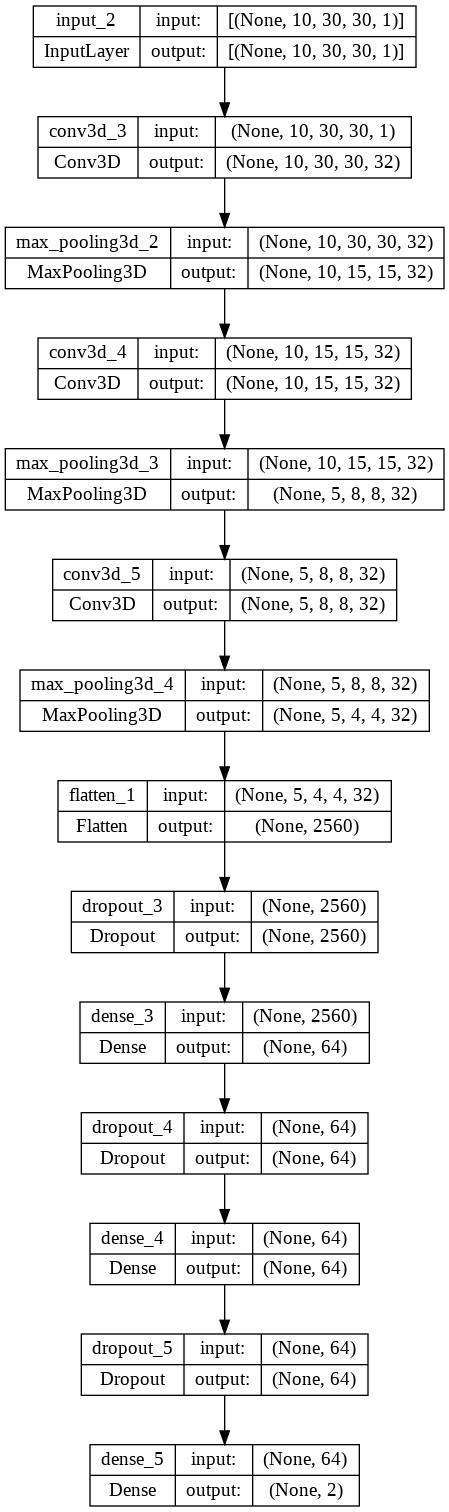

In [ ]:
plot_model(model2,show_shapes=True, show_layer_names=True)

**MODEL 3**

In [ ]:
adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model3.compile(
    loss= custom_crossentropy(bce),
    optimizer=adam,
    metrics=['acc',f1score,precision, recall]
)

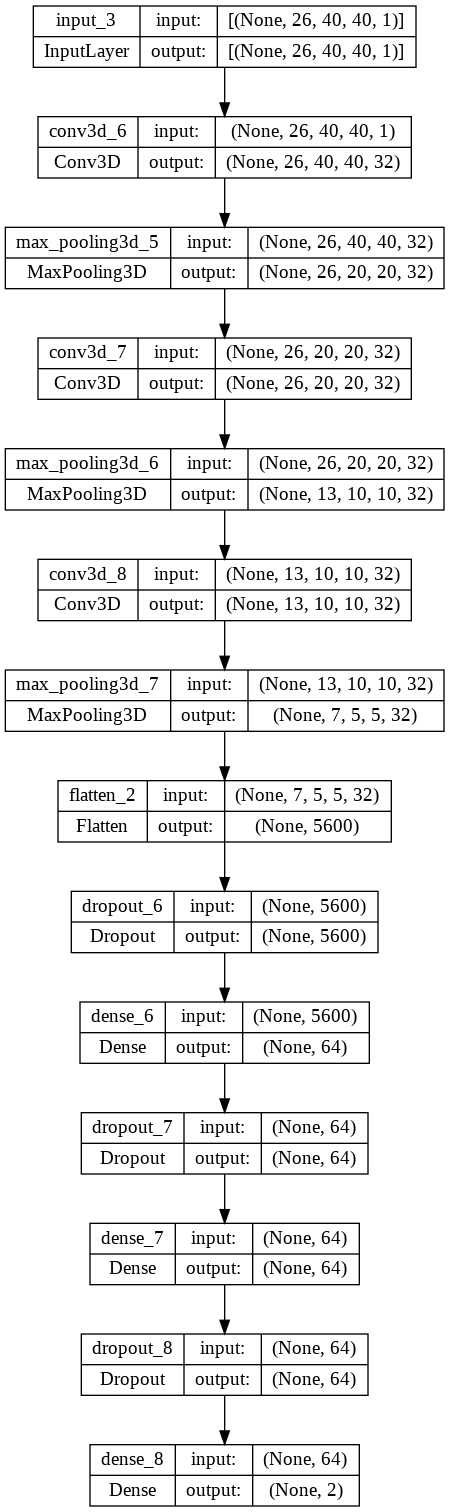

In [ ]:
plot_model(model3,show_shapes=True, show_layer_names=True)

#**Checkpoints definition MODEL1**

In [ ]:
earlystop_patience = 10 # 
earlystopper = EarlyStopping(patience=earlystop_patience, verbose=1)

In [ ]:
CALLBACKS_FOLDER =  os.path.join(root, 'ARCH_1_no_res')
os.makedirs(CALLBACKS_FOLDER, exist_ok=True)


In [ ]:
# Example of checkpointer based on values of F1-score in the validation set 
checkpointer_val_f1score = ModelCheckpoint(filepath=CALLBACKS_FOLDER + "/best_max_val_f1score_no_res.h5",
                                          monitor='val_f1score',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max',
                                          period=1)


#**Checkpoints definition MODEL2**

In [ ]:
earlystop_patience = 10 
earlystopper2 = EarlyStopping(patience=earlystop_patience, verbose=1)

In [ ]:
CALLBACKS_FOLDER2 =  os.path.join(root, 'ARCH_2_no_res')
os.makedirs(CALLBACKS_FOLDER2, exist_ok=True)

In [ ]:
# Example of checkpointer based on values of F1-score in the validation set 
checkpointer_val_f1score2 = ModelCheckpoint(filepath=CALLBACKS_FOLDER2 + "/best_max_val_f1score_no_res.h5",
                                          monitor='val_f1score',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max',
                                          period=1)


#**Checkpoints definition MODEL3**

In [ ]:
earlystop_patience = 10 
earlystopper3 = EarlyStopping(patience=earlystop_patience, verbose=1)

In [ ]:
CALLBACKS_FOLDER3 =  os.path.join(root, 'ARCH_3_no_res')
os.makedirs(CALLBACKS_FOLDER3, exist_ok=True)

In [ ]:
# Example of checkpointer based on values of F1-score in the validation set 
checkpointer_val_f1score3 = ModelCheckpoint(filepath=CALLBACKS_FOLDER3 + "/best_max_val_f1score_no_res.h5",
                                          monitor='val_f1score',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='max',
                                          period=1)


#**Models Training**

In [ ]:
history1 = model1.fit(x = training_generator, #Give the generator as input data
          validation_data = (val_images,val_labels), #Give directly all images and labels for the validation set. 
          epochs = 30, steps_per_epoch = steps,
          callbacks =[earlystopper,checkpointer_val_f1score], #Multiple checkpointer can be considered
          verbose =1)

(14824, 2)
 array([[ 256,    0],
       [ 257,  270],
       [ 259,   90],
       ...,
       [7126,   90],
       [7129,   90],
       [7148,  180]])
Epoch 1/30
98/98 [==============================] - ETA: 0s - loss: 88.9118 - acc: 0.6638 - f1score: 0.6004 - precision: 0.6883 - recall: 0.5948
Epoch 1: val_f1score improved from -inf to 0.65904, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_1_no_res/best_max_val_f1score_no_res.h5
98/98 [==============================] - 41s 331ms/step - loss: 88.9118 - acc: 0.6638 - f1score: 0.6004 - precision: 0.6883 - recall: 0.5948 - val_loss: 9.1389 - val_acc: 0.9132 - val_f1score: 0.6590 - val_precision: 0.6694 - val_recall: 0.7502
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 44.7515 - acc: 0.8784 - f1score: 0.8759 - precision: 0.8815 - recall: 0.8768
Epoch 2: val_f1score improved from 0.65904 to 0.77396, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_1_no_res/best_max_val_f1score_no_res.h5
98/

In [ ]:
history2 = model2.fit(x = training_generator2, #Give the generator as input data
          validation_data = (val_images2,val_labels), #Give directly all images and labels for the validation set. 
          epochs = 30, steps_per_epoch = steps,
          callbacks =[earlystopper2,checkpointer_val_f1score2], #Multiple checkpointer can be considered
          verbose =1)

(14824, 2)
 array([[6702,  270],
       [5891,  270],
       [2893,    0],
       ...,
       [4245,  180],
       [5510,  270],
       [1858,    0]])
Epoch 1/30
98/98 [==============================] - ETA: 0s - loss: 85.6160 - acc: 0.6921 - f1score: 0.6219 - precision: 0.6880 - recall: 0.6192
Epoch 1: val_f1score improved from -inf to 0.63921, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_2_no_res/best_max_val_f1score_no_res.h5
98/98 [==============================] - 41s 408ms/step - loss: 85.6160 - acc: 0.6921 - f1score: 0.6219 - precision: 0.6880 - recall: 0.6192 - val_loss: 11.6793 - val_acc: 0.8817 - val_f1score: 0.6392 - val_precision: 0.5694 - val_recall: 0.8379
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 41.0487 - acc: 0.8962 - f1score: 0.8927 - precision: 0.9073 - recall: 0.8827
Epoch 2: val_f1score improved from 0.63921 to 0.71139, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_2_no_res/best_max_val_f1score_no_res.h5
98

In [ ]:
history3 = model3.fit(x = training_generator3, #Give the generator as input data
          validation_data = (val_images3,val_labels), #Give directly all images and labels for the validation set. 
          epochs = 30, steps_per_epoch = steps,
          callbacks =[earlystopper3,checkpointer_val_f1score3], #Multiple checkpointer can be considered
          verbose =1)

(14824, 2)
 array([[5878,  270],
       [5764,    0],
       [ 430,   90],
       ...,
       [ 347,  180],
       [6549,   90],
       [6255,  270]])
Epoch 1/30
98/98 [==============================] - ETA: 0s - loss: 83.9272 - acc: 0.7010 - f1score: 0.6278 - precision: 0.7483 - recall: 0.6105
Epoch 1: val_f1score improved from -inf to 0.65295, saving model to /content/gdrive/MyDrive/Neuroengineering/ARCH_3_no_res/best_max_val_f1score_no_res.h5
98/98 [==============================] - 123s 1s/step - loss: 83.9272 - acc: 0.7010 - f1score: 0.6278 - precision: 0.7483 - recall: 0.6105 - val_loss: 9.2518 - val_acc: 0.9051 - val_f1score: 0.6529 - val_precision: 0.5968 - val_recall: 0.8169
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 40.3113 - acc: 0.8952 - f1score: 0.8915 - precision: 0.9141 - recall: 0.8745
Epoch 2: val_f1score did not improve from 0.65295
98/98 [==============================] - 116s 1s/step - loss: 40.3113 - acc: 0.8952 - f1score: 0.8915 - precisio

##**Results on the training set**
### For the entire set of monitored metrics we can check the trend during training

**MODEL 1**

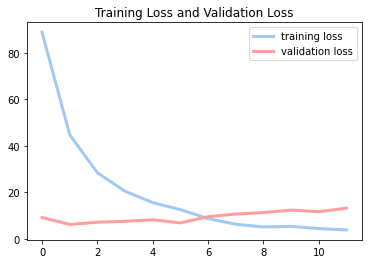

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training Loss and Validation Loss')

plt.plot(history1.history['loss'], color=sns.color_palette('pastel')[0], label="training loss", linewidth=3)
plt.plot(history1.history['val_loss'],color=sns.color_palette('pastel')[3], label="validation loss", linewidth=3)
plt.legend()
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'Loss_model1'))

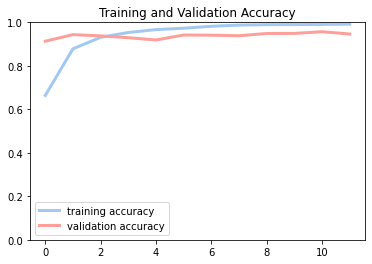

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Accuracy')
plt.plot(history1.history['acc'],color=sns.color_palette('pastel')[0], linewidth=3, label="training accuracy")
plt.plot(history1.history['val_acc'],color=sns.color_palette('pastel')[3],linewidth=3, label="validation accuracy")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'Acc_model1'))

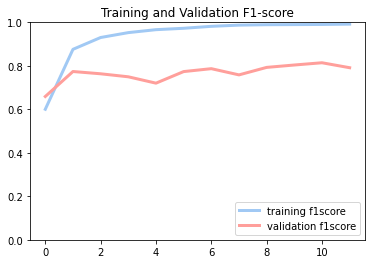

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation F1-score')
plt.plot(history1.history['f1score'], color=sns.color_palette('pastel')[0], linewidth=3,label="training f1score")
plt.plot(history1.history['val_f1score'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation f1score")
plt.legend( loc = 'lower right')
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'f1score_PERM_UNDER1'))

In [ ]:
print(np.max(history1.history['f1score']))

0.991887629032135


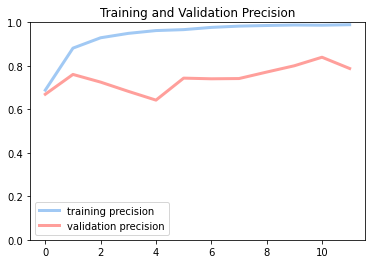

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Precision')
plt.plot(history1.history['precision'], color=sns.color_palette('pastel')[0], linewidth=3,label="training precision")
plt.plot(history1.history['val_precision'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation precision")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'precision_PERM_UNDER1'))

**MODEL 2**

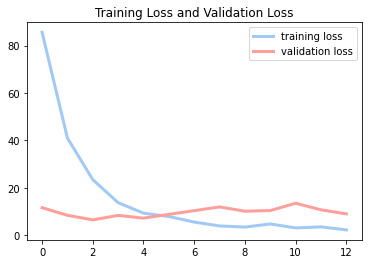

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training Loss and Validation Loss')

plt.plot(history2.history['loss'], color=sns.color_palette('pastel')[0], linewidth=3,label="training loss")
plt.plot(history2.history['val_loss'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation loss")
plt.legend()
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'Loss_model2'))

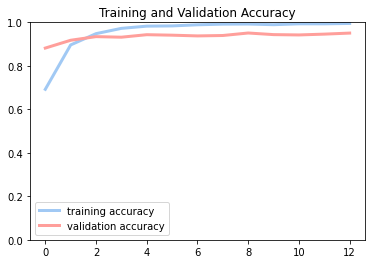

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Accuracy')
plt.plot(history2.history['acc'], color=sns.color_palette('pastel')[0], linewidth=3,label="training accuracy")
plt.plot(history2.history['val_acc'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation accuracy")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'Acc_model2'))

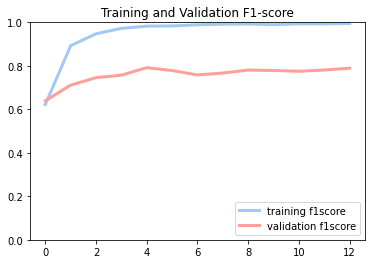

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation F1-score')
plt.plot(history2.history['f1score'], color=sns.color_palette('pastel')[0], linewidth=3,label="training f1score")
plt.plot(history2.history['val_f1score'], color=sns.color_palette('pastel')[3], linewidth=3, label="validation f1score")
plt.legend(loc = 'lower right')
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'f1score_PERM_UNDER2'))

In [ ]:
print(np.max(history2.history['f1score']))

0.9949164986610413


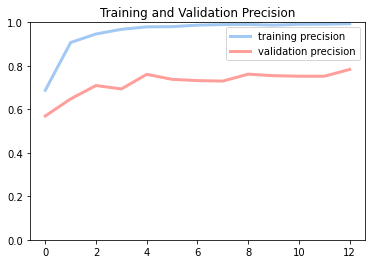

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Precision')
plt.plot(history2.history['precision'], color=sns.color_palette('pastel')[0], linewidth=3,label="training precision")
plt.plot(history2.history['val_precision'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation precision")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'precision_PERM_UNDER1'))

**MODEL 3**

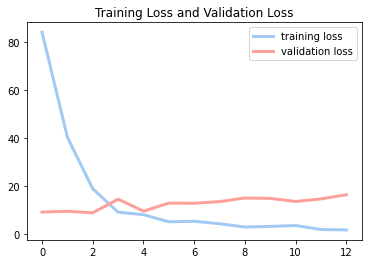

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training Loss and Validation Loss')

plt.plot(history3.history['loss'], color=sns.color_palette('pastel')[0], linewidth=3,label="training loss")
plt.plot(history3.history['val_loss'], color=sns.color_palette('pastel')[3], linewidth=3,label="validation loss")
plt.legend()
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'Loss_model3'))

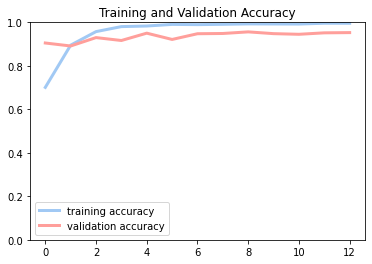

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Accuracy')
plt.plot(history3.history['acc'], color=sns.color_palette('pastel')[0], linewidth=3,label="training accuracy")
plt.plot(history3.history['val_acc'], color=sns.color_palette('pastel')[3], linewidth=3,label="validation accuracy")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'Acc_model3'))

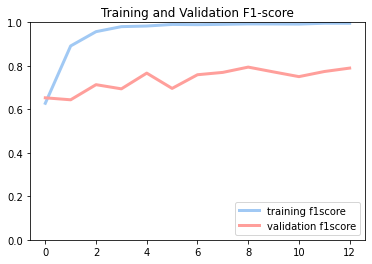

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation F1-score')
plt.plot(history3.history['f1score'], color=sns.color_palette('pastel')[0], linewidth=3,label="training f1score")
plt.plot(history3.history['val_f1score'], color=sns.color_palette('pastel')[3], linewidth=3,label="validation f1score")
plt.legend(loc = 'lower right')
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'f1score_PERM_UNDER3'))

In [ ]:
print(np.max(history3.history['f1score']))

0.9959525465965271


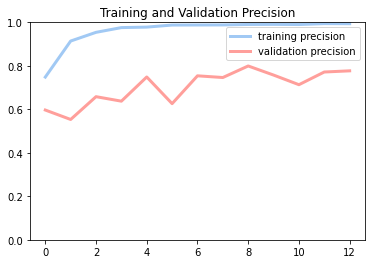

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Training and Validation Precision')
plt.plot(history3.history['precision'], color=sns.color_palette('pastel')[0], linewidth=3,label="training precision")
plt.plot(history3.history['val_precision'],color=sns.color_palette('pastel')[3], linewidth=3,label="validation precision")
plt.legend()
plt.ylim(0,1)
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'precision_PERM_UNDER1'))

#**Model restoring**

In [ ]:
arch1_restored = load_model(root + "/ARCH_1_no_res/best_max_val_f1score_no_res.h5",compile=False)
arch2_restored = load_model(root + "/ARCH_2_no_res/best_max_val_f1score_no_res.h5",compile=False)
arch3_restored = load_model(root + "/ARCH_3_no_res/best_max_val_f1score_no_res.h5",compile=False)

###Make the prediction on the validation dataset

In [ ]:
# PREDICTION of THE CLASSIFICATION PROBABILITIES NEEDED TO CONSTRUCT THE FEATURES MATRIX FOR THE TRAINING SET
y_pred_val = arch1_restored.predict(val_images)
y_pred_val2 = arch2_restored.predict(val_images2)
y_pred_val3 = arch3_restored.predict(val_images3)

print(y_pred_val3)
y_pred_val = np.asarray(y_pred_val)[:,0]
y_pred_val2 = np.asarray(y_pred_val2)[:,0]
y_pred_val3 = np.asarray(y_pred_val3)[:,0]

print(np.shape(y_pred_val))
print(np.shape(y_pred_val2))
print(np.shape(y_pred_val3))

85/85 [==============================] - 2s 23ms/step
[[1.9288882e-16 1.0000000e+00]
 [4.5572723e-10 1.0000000e+00]
 [1.5174948e-30 1.0000000e+00]
 ...
 [1.0000000e+00 2.6394566e-12]
 [1.0000000e+00 2.6394566e-12]
 [4.5547206e-02 9.5445275e-01]]
(2697,)
(2697,)
(2697,)


In [ ]:
print(np.shape(val_labels))
val_target = np.asarray(val_labels)[:,0]
np.shape(val_target)

(2697, 2)


(2697,)

# **Metrics calculation and results visualization on the validation set**

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_curve,auc,roc_curve, precision_score, recall_score, f1_score
import seaborn as sn

**MODEL 1**

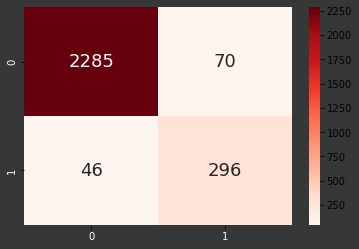

In [ ]:
selected_thr = 0.5

#Confusion Matrix
CM = confusion_matrix(val_target,y_pred_val>=selected_thr)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Reds)
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix.png'), facecolor=fig.get_facecolor() )

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_target,y_pred_val>=selected_thr).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
Se = round(tp/(tp+fn),2)
Pr = round(tp/(tp+fp),2) 
print("(Se,Pr)=("+str(Se)+","+str(Pr)+")")

2285
70
46
296
(Se,Pr)=(0.87,0.81)


In [ ]:
#Accuracy
acc = accuracy_score(val_target,y_pred_val>=selected_thr)
acc

0.956989247311828

**MODEL 2**

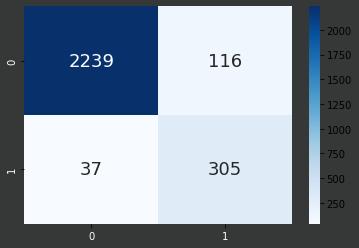

In [ ]:
selected_thr = 0.5

# Confusion Matrix
CM = confusion_matrix(val_target,y_pred_val2>=selected_thr)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Blues) 
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix.png'), facecolor=fig.get_facecolor() )

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_target,y_pred_val2>=selected_thr).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
Se = round(tp/(tp+fn),2) # Recall (Sensitivity)
Pr = round(tp/(tp+fp),2) # Precision
print("(Se,Pr)=("+str(Se)+","+str(Pr)+")")

2239
116
37
305
(Se,Pr)=(0.89,0.72)


In [ ]:
#Accuracy
acc = accuracy_score(val_target,y_pred_val2>=selected_thr)
acc

0.9432703003337041

**MODEL 3**

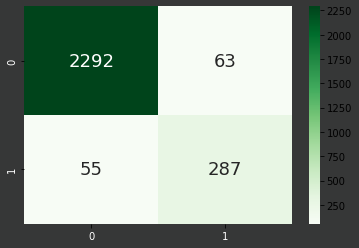

In [ ]:
selected_thr = 0.5

# Confusion Matrix
CM = confusion_matrix(val_target,y_pred_val3>=selected_thr)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Greens) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix.png'), facecolor=fig.get_facecolor() )

In [ ]:
tn, fp, fn, tp = confusion_matrix(val_target,y_pred_val3>=selected_thr).ravel()
print(tn)
print(fp)
print(fn)
print(tp)
Se = round(tp/(tp+fn),2) # Recall (Sensitivity)
Pr = round(tp/(tp+fp),2) # Precision
print("(Se,Pr)=("+str(Se)+","+str(Pr)+")")

2292
63
55
287
(Se,Pr)=(0.84,0.82)


In [ ]:
#Accuracy
acc = accuracy_score(val_target,y_pred_val3>=selected_thr)
acc

0.9562476826103078

# **PRC and ROC curve on the validation set**

**Model 1**

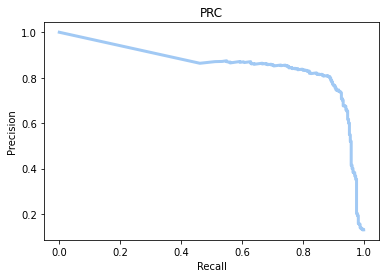

AUPRC TEST-SET : 0.85


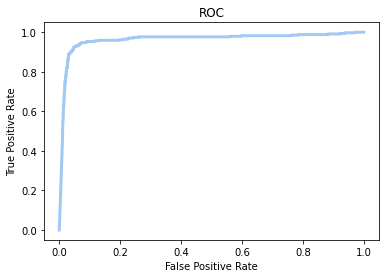

AUROC: 0.96


In [ ]:
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(val_target,y_pred_val)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'PRC_NO_RES'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(val_target,y_pred_val)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER, 'AUROC_NO_RES'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))


In [ ]:
from keras.engine.training import h5py

In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER, 'Data_NO_RES_CORRECT.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc)
    f.create_dataset('prec', data=prec)
    f.create_dataset('rec', data=rec)
    f.create_dataset('thr_auprc', data=thr_auprc)
    f.create_dataset('fpr', data=fpr)
    f.create_dataset('tpr', data=tpr)
    f.create_dataset('thr_auc', data=thr_auc)
    f.close

**Model 2**

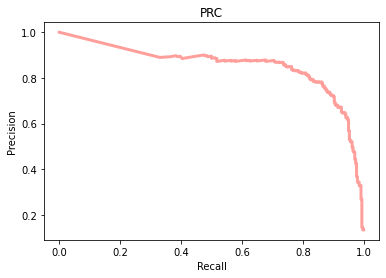

AUPRC TEST-SET : 0.85


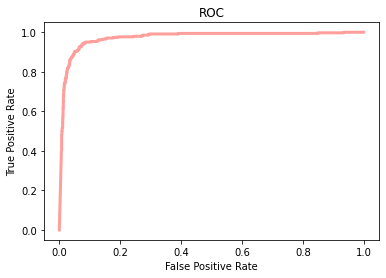

AUROC: 0.97


In [ ]:
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(val_target,y_pred_val2)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[3], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'PRC_NO_RES'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(val_target,y_pred_val2)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[3], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER2, 'AUROC_NO_RES'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER2, 'Data_NO_RES_CORRECT.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc)
    f.create_dataset('prec', data=prec)
    f.create_dataset('rec', data=rec)
    f.create_dataset('thr_auprc', data=thr_auprc)
    f.create_dataset('fpr', data=fpr)
    f.create_dataset('tpr', data=tpr)
    f.create_dataset('thr_auc', data=thr_auc)
    f.close

**Model 3**

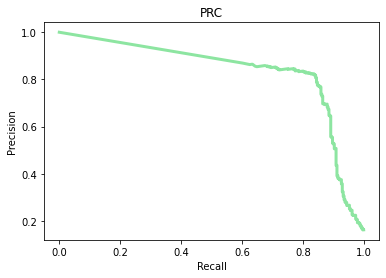

AUPRC TEST-SET : 0.84


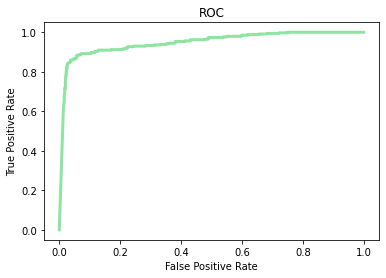

AUROC: 0.95


In [ ]:
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(val_target,y_pred_val3)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[2], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'PRC_NO_RES'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(val_target,y_pred_val3)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[2], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER3, 'AUROC_NO_RES'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

In [ ]:
#saving the data value in a file
with h5py.File(os.path.join(CALLBACKS_FOLDER3, 'Data_NO_RES_CORRECT.hdf5'), 'w') as f:
    f.create_dataset('accuracy', data=acc)
    f.create_dataset('prec', data=prec)
    f.create_dataset('rec', data=rec)
    f.create_dataset('thr_auprc', data=thr_auprc)
    f.create_dataset('fpr', data=fpr)
    f.create_dataset('tpr', data=tpr)
    f.create_dataset('thr_auc', data=thr_auc)
    f.close

# **MODELS COMBINATION as Dou et al.**

In [ ]:
#TRAIN
#labels vector
y_train = y[list(idx_train),0]
# branch 1 image
trainREG_ARCH1_images = np.expand_dims(h5file.root.images[list(idx_train),10:16,10:30,10:30],axis=-1)
trainREG_ARCH1_images = normalize(trainREG_ARCH1_images)
#branch 2 image
trainREG_ARCH2_images = np.expand_dims(h5file.root.images[list(idx_train),10:20,10:40,10:40],axis=-1)
trainREG_ARCH2_images = normalize(trainREG_ARCH2_images)
#branch 3 image
trainREG_ARCH3_images = np.expand_dims(h5file.root.images[list(idx_train),0:26,0:40,0:40],axis=-1)
trainREG_ARCH3_images = normalize(trainREG_ARCH3_images)

# PREDICT PROBABILITIES WITH THE RESTORED MODELS ON TRAIN SET
#branch 1 probabilities 
y_pred_arch1_train = arch1_restored.predict(trainREG_ARCH1_images)
#branch 2 probabilities 
y_pred_arch2_train = arch2_restored.predict(trainREG_ARCH2_images)
#branch 3 probabilities 
y_pred_arch3_train = arch3_restored.predict(trainREG_ARCH3_images)

140/140 [==============================] - 3s 24ms/step


In [ ]:
#VALIDATION
y_val = y[list(idx_val),0]
y_pred_arch1_val = arch1_restored.predict(val_images)
#branch 2 probabilities 
y_pred_arch2_val = arch2_restored.predict(val_images2)
#branch 3 probabilities 
y_pred_arch3_val = arch3_restored.predict(val_images3)

85/85 [==============================] - 2s 23ms/step


In [ ]:
y_pred_arch1_train = y_pred_arch1_train[:,0]
y_pred_arch2_train = y_pred_arch2_train[:,0]
y_pred_arch3_train = y_pred_arch3_train[:,0]
y_pred_arch1_val = y_pred_arch1_val[:,0]
y_pred_arch2_val = y_pred_arch2_val[:,0]
y_pred_arch3_val = y_pred_arch3_val[:,0]


In [ ]:
#define the grid of weights to be investigated
values_grid = np.arange(0.01, 0.99, 0.01);
def prediction_from_array (y1, y2, y3, a, b, c):
  lista =[]
  for i in range (len(y1)):
   h = a*y1[i] + b*y2[i] + c*y3[i]
   lista.append(h)
  return lista

In [ ]:
#TRAIN
best_train = [0, 0, 0]
area_max = 0
for a in values_grid:
  for b in values_grid:
    for c in values_grid:
      if(a+b+c == 1):
        y_pred = prediction_from_array(y_pred_arch1_train,y_pred_arch2_train,y_pred_arch3_train, a, b, c);
        y_pred = np.asarray(y_pred)
        prec, rec, thr_auprc=precision_recall_curve(y_train,y_pred>=0.5)
        fpr, tpr, thr_auc=roc_curve(y_train,y_pred>=0.5)
        auprc = auc(rec,prec)
        auroc = auc(fpr,tpr)
        if(auprc > area_max):
          area_max = auprc
          best_train[0] = a
          best_train[1] = b
          best_train[2] = c

print(best_train)

[0.09, 0.41000000000000003, 0.5]


In [ ]:
#VALIDATION
best_val = [0, 0, 0]
area_max = 0
for a in values_grid:
  for b in values_grid:
    for c in values_grid:
      if(a+b+c == 1):
        y_pred = prediction_from_array(y_pred_arch1_val,y_pred_arch2_val,y_pred_arch3_val, a, b, c);
        y_pred = np.asarray(y_pred)
        prec, rec, thr_auprc=precision_recall_curve(y_val,y_pred>=0.5)
        fpr, tpr, thr_auc=roc_curve(y_val,y_pred>=0.5)
        auprc = auc(rec,prec)
        auroc = auc(fpr,tpr)
        if(auprc > area_max):
          area_max = auprc
          best_val[0] = a
          best_val[1] = b
          best_val[2] = c

print(best_val)

[0.49, 0.46, 0.05]


In [ ]:
y_pred_multibranch_train = prediction_from_array(y_pred_arch1_train,y_pred_arch2_train,y_pred_arch3_train, best_train[0], best_train[1], best_train[2])
y_pred_multibranch_train = np.asarray(y_pred_multibranch_train)
y_pred_multibranch_val= prediction_from_array(y_pred_arch1_val,y_pred_arch2_val,y_pred_arch3_val,best_val[0], best_val[1], best_val[2])
y_pred_multibranch_val = np.asarray(y_pred_multibranch_val)

In [ ]:
CALLBACKS_FOLDER_MULTI = os.path.join(root, 'ARCH_MULTIBRANCH')
os.makedirs(CALLBACKS_FOLDER_MULTI, exist_ok=True)

In [ ]:
y_train

array([1, 0, 0, ..., 0, 0, 1], dtype=int32)

In [ ]:
y_pred_multibranch_train

array([9.99906333e-01, 5.49988416e-03, 5.83915213e-03, ...,
       2.08588910e-04, 2.35285062e-04, 9.97412701e-01])

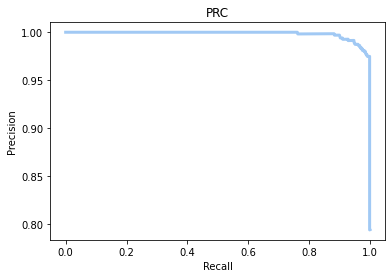

AUPRC TEST-SET : 1.0


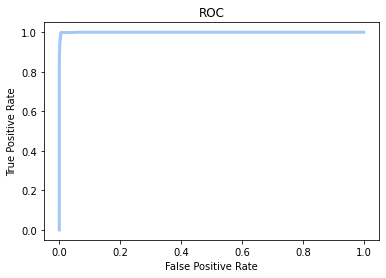

AUROC: 1.0


In [ ]:
#TRAIN
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(y_train,y_pred_multibranch_train)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'PRC_NO_RES_TRAIN'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(y_train,y_pred_multibranch_train)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[0], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'AUROC_NO_RES_TRAIN'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

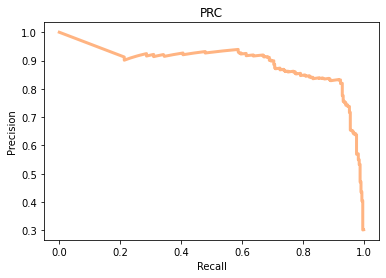

AUPRC TEST-SET : 0.89


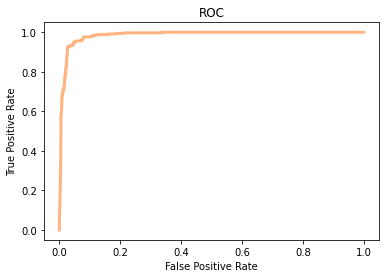

AUROC: 0.99


In [ ]:
#VALIDATION
# Compute PRC
prec, rec, thr_auprc=precision_recall_curve(y_val,y_pred_multibranch_val)
fig, ax = plt.subplots()
plt.plot(rec,prec,color=sns.color_palette('pastel')[1], linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'PRC_NO_RES_VAL'))
print("AUPRC TEST-SET : "+str(round(auc(rec,prec),2)))

# Compute ROC
fpr, tpr, thr_auc=roc_curve(y_val,y_pred_multibranch_val)
fig, ax = plt.subplots()
plt.plot(fpr,tpr,color=sns.color_palette('pastel')[1], linewidth=3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
fig.savefig(os.path.join(CALLBACKS_FOLDER_MULTI, 'AUROC_NO_RES_VAL'))
print('AUROC: '+ str(round(auc(fpr,tpr),2)))

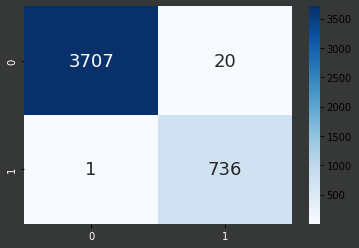

In [ ]:
#TRAINING
# Confusion Matrix
CM = confusion_matrix(y_train,y_pred_multibranch_train>=0.5)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Blues) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix_train_multi.png'), facecolor=fig.get_facecolor() )

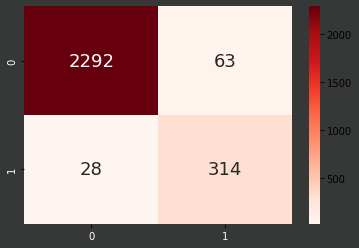

In [ ]:
#VALIDATION
# Confusion Matrix
CM = confusion_matrix(y_val,y_pred_multibranch_val>=0.5)
fig = plt.figure()
fig.set_facecolor('xkcd:dark grey')
ax = sn.heatmap(CM, annot=True, annot_kws={"size": 18}, fmt='g', cmap=plt.cm.Reds) # font size
plt.xticks(color='white')
plt.yticks(color = 'white')
plt.show()
fig.savefig(os.path.join(graph, '/confusion_matrix_val_multi.png'), facecolor=fig.get_facecolor() )

## **Accuracy**

In [ ]:
#ACCURACY of different models ON VALIDATION SET
acc_model1 = accuracy_score(val_target,y_pred_val>=selected_thr)
acc_model2 = accuracy_score(val_target,y_pred_val2>=selected_thr)
acc_model3 = accuracy_score(val_target,y_pred_val3>=selected_thr)
print("Accuracy Model 1:       {}".format(acc_model1))
print("Accuracy Model 2:       {}".format(acc_model2))
print("Accuracy Model 3:       {}".format(acc_model3))

Accuracy Model 1:       0.956989247311828
Accuracy Model 2:       0.9432703003337041
Accuracy Model 3:       0.9562476826103078


In [ ]:
#ACCURACY of different models ON TRAINING SET
acc_model1 = accuracy_score(y_train,y_pred_arch1_train>=selected_thr)
acc_model2 = accuracy_score(y_train,y_pred_arch2_train>=selected_thr)
acc_model3 = accuracy_score(y_train,y_pred_arch3_train>=selected_thr)
print("Accuracy Model 1:       {}".format(acc_model1))
print("Accuracy Model 2:       {}".format(acc_model2))
print("Accuracy Model 3:       {}".format(acc_model3))

Accuracy Model 1:       0.9858870967741935
Accuracy Model 2:       0.9693100358422939
Accuracy Model 3:       0.9910394265232975


In [ ]:
#ACCURACY of multibranch ON TRAINING AND VALIDATION SET 
acc_train = accuracy_score(y_train,y_pred_multibranch_train>=0.5)
acc_val  =  accuracy_score(y_val,  y_pred_multibranch_val>=0.5)
print("Accuracy on train set:      {}".format(acc_train))
print("Accuracy on validation:     {}".format(acc_val))

Accuracy on train set:      0.9952956989247311
Accuracy on validation:     0.9662588060808306


## **F1 score**

In [ ]:
#f1 scores of different models on VALIDATION SET 
f1_model1 = f1_score(val_target,y_pred_val>=selected_thr)
f1_model2 = f1_score(val_target,y_pred_val2>=selected_thr)
f1_model3 = f1_score(val_target,y_pred_val3>=selected_thr)
print("F1 Model 1:        {}".format(f1_model1))
print("F1 Model 2:        {}".format(f1_model2))
print("F1 Model 3:        {}".format(f1_model3))

F1 Model 1:        0.8361581920903954
F1 Model 2:        0.799475753604194
F1 Model 3:        0.8294797687861271


In [ ]:
#f1 scores of different models on TRAINING SET 
f1_model1 = f1_score(y_train,y_pred_arch1_train>=selected_thr)
f1_model2 = f1_score(y_train,y_pred_arch2_train>=selected_thr)
f1_model3 = f1_score(y_train,y_pred_arch3_train>=selected_thr)
print("F1 Model 1:        {}".format(f1_model1))
print("F1 Model 2:        {}".format(f1_model2))
print("F1 Model 3:        {}".format(f1_model3))

F1 Model 1:        0.958634274458306
F1 Model 2:        0.9142141515341266
F1 Model 3:        0.9735449735449736


In [ ]:
#f1 score of multibranch ON TRAINING AND VALIDATION SET
f1_train = f1_score(y_train,y_pred_multibranch_train>=0.5)
f1_val = f1_score(y_val,y_pred_multibranch_val>=0.5)
print("F1 on train set:      {}".format(f1_train))
print("F1 on validation:     {}".format(f1_val))

F1 on train set:      0.9859343603482921
F1 on validation:     0.8734353268428372


## **Recall**

In [ ]:
#RECALL of different models on VALIDATION SET 
recall1 = recall_score(val_target,y_pred_val>=selected_thr)
recall2 = recall_score(val_target,y_pred_val2>=selected_thr)
recall3 = recall_score(val_target,y_pred_val3>=selected_thr)
print("Recall Model 1:        {}".format(recall1))
print("Recall Model 2:        {}".format(recall2))
print("Recall Model 3:        {}".format(recall3))

Recall Model 1:        0.8654970760233918
Recall Model 2:        0.8918128654970761
Recall Model 3:        0.8391812865497076


In [ ]:
#recall of different models on TRAINING SET 
recall_model1 = recall_score(y_train,y_pred_arch1_train>=selected_thr)
recall_model2 = recall_score(y_train,y_pred_arch2_train>=selected_thr)
recall_model3 = recall_score(y_train,y_pred_arch3_train>=selected_thr)
print("Recall Model 1:        {}".format(recall_model1))
print("Recall Model 2:        {}".format(recall_model2))
print("Recall Model 3:        {}".format(recall_model3))

Recall Model 1:        0.9905020352781547
Recall Model 2:        0.9905020352781547
Recall Model 3:        0.9986431478968792


In [ ]:
#recall of multibranch ON TRAINING AND VALIDATION SET
recall_train = recall_score(y_train,y_pred_multibranch_train>=0.5)
recall_val = recall_score(y_val,y_pred_multibranch_val>=0.5)
print("Recall on train set:      {}".format(recall_train))
print("Recall on validation:     {}".format(recall_val))

Recall on train set:      0.9986431478968792
Recall on validation:     0.9181286549707602


## **Precision**

In [ ]:
#Precision of different models on VALIDATION SET 
precision_model1 = precision_score(val_target,y_pred_val>=selected_thr)
precision_model2 = precision_score(val_target,y_pred_val2>=selected_thr)
precision_model3 = precision_score(val_target,y_pred_val3>=selected_thr)
print("Precision Model 1:       {}".format(precision_model1))
print("Precision Model 2:       {}".format(precision_model2))
print("Precision Model 3:       {}".format(precision_model3))

Precision Model 1:       0.8087431693989071
Precision Model 2:       0.7244655581947743
Precision Model 3:       0.82


In [ ]:
#Precision of different models on TRAINING SET 
precision_model1 = precision_score(y_train,y_pred_arch1_train>=selected_thr)
precision_model2 = precision_score(y_train,y_pred_arch2_train>=selected_thr)
precision_model3 = precision_score(y_train,y_pred_arch3_train>=selected_thr)
print("Precision Model 1:       {}".format(precision_model1))
print("Precision Model 2:       {}".format(precision_model2))
print("Preicion Model 3:        {}".format(precision_model3))

Precision Model 1:       0.9287531806615776
Precision Model 2:       0.8488372093023255
Preicion Model 3:        0.9496774193548387


In [ ]:
#precision of multibranch ON TRAINING AND VALIDATION SET
precision_train = precision_score(y_train,y_pred_multibranch_train>=0.5)
precision_val = precision_score(y_val,y_pred_multibranch_val>=0.5)
print("Precision on train set:      {}".format(precision_train))
print("Precision on validation:     {}".format(precision_val))

Precision on train set:      0.9735449735449735
Precision on validation:     0.8328912466843501
